In [ ]:
# Enable Float64 for more stable matrix inversions.
from jax import config
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt

from examples.utils import (
    clean_legend,
    use_mpl_style,
)

config.update("jax_enable_x64", True)


with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx


key = jr.key(123)
""""Critical line for using JAX. jr.key() stands for jax.random.key()
In JAX, random number generation is pure and deterministic. To generate any random 
number you must first provide a stateful key
What it does: create an initial pseudorandom number generator PRNG key
123 is the seed. Using the same seed produces the same initial key (guarantees reproducible generated data)
In JAX the key must be passed to every random function call"""

# set the default style for plotting
use_mpl_style()

cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

/Users/sarac/Downloads/gpjax/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
n = 100 #num of data pts to be generated
noise = 0.3 #std dev of the Gaussian noise(sigma) that will be added to the true func ouput

key, subkey = jr.split(key)
"""This is a crucial step in JAX for generating multiple independent random numbers. 
It takes the existing PRNG key (which was previously seeded as jr.key(123)) 
and splits it into two new, independent keys: key (which is overwritten) and subkey. 
This ensures that the random process for generating the input data x is independent 
from the random process for generating the noise."""

x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
"""This generates the input data points x. 
It samples n (100) values uniformly at random between -3.0 and 3.0
using the first key. The .reshape(-1, 1) is used to turn the 1D array into a 2D column vector 
(a requirement for GPJax/JAX datasets)."""

f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
"Defines the true, underlying function f(x) = sin(4x) + cos(2x). "
"This is the latent function the GP model aims to recover."

signal = f(x)
"Calculates the true, noiseless output f(x) by applying the function f to the generated input data x."

y = signal + jr.normal(subkey, shape=signal.shape) * noise
"This generates the observed data points y. "
"It takes the signal and adds Gaussian noise to it."
"The noise is generated using jr.normal(subkey, ...) "
"(using the second, independent key) and scaled by the noise standard deviation (0.3)."

D = gpx.Dataset(X=x, y=y)
"""Bundles the generated input data x and noisy output data y into a GPJax Dataset object, D,
 which is the format required for training the GP model."""

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
"""Creates a new set of input points for prediction x_test. 
It generates 500 evenly spaced points from -3.5 to 3.5. 
These points will be used later to plot the GP's prediction across the function's domain."""

ytest = f(xtest)
"Calculates the true, noiseless output for the test points. "
"This is the ground truth that the model's prediction will be compared against in the final plots."

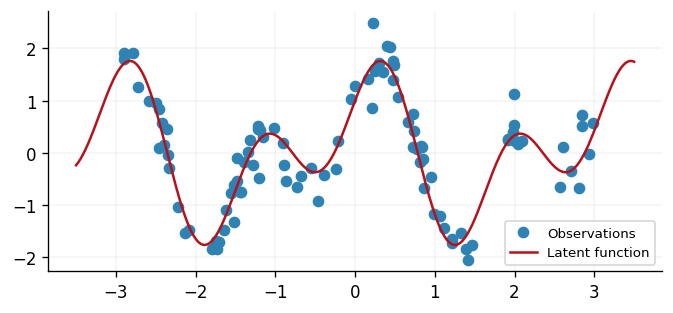

In [3]:
fig, ax = plt.subplots()
ax.plot(x, y, "o", label="Observations", color=cols[0])
ax.plot(xtest, ytest, label="Latent function", color=cols[1])
ax.legend(loc="best")

##### The aim for this tutorial will be to reconstruct the latent function from noisy observations D via GP regression. Next section defines a GP prior.
### Defining the prior

In [4]:
kernel = gpx.kernels.RBF()  # 1-dimensional input
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

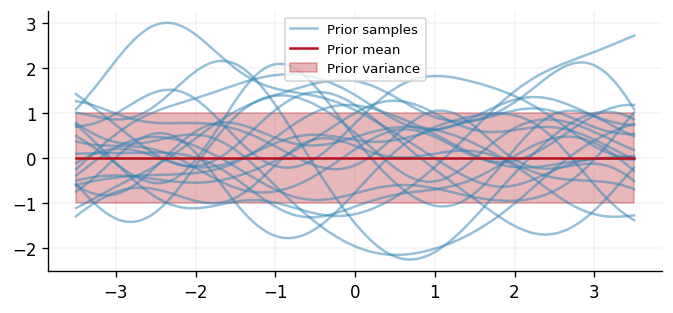

In [5]:
prior_dist = prior.predict(xtest)

prior_mean = prior_dist.mean
prior_std = prior_dist.variance
samples = prior_dist.sample(key=key, sample_shape=(20,))


fig, ax = plt.subplots()
ax.plot(xtest, samples.T, alpha=0.5, color=cols[0], label="Prior samples")
ax.plot(xtest, prior_mean, color=cols[1], label="Prior mean")
ax.fill_between(
    xtest.flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    alpha=0.3,
    color=cols[1],
    label="Prior variance",
)
ax.legend(loc="best")
ax = clean_legend(ax)

#### Constructing the Posterior 

In [6]:
# Calling Gaussian instance
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)

# The posterior is proportional to the prior multiplied by the likelihood
posterior = prior * likelihood

### In this particular model, we have 3 parameters:
#### Kernel lengthscale, Kernel variance, and the Observation noise variance
#### Each is initilaized to 1 but we can learn these parameters by optimising the marginal log likelihood mll

In [7]:
print(-gpx.objectives.conjugate_mll(posterior, D))


132.64625942003744


In [8]:
#We can now define an optimiser. For this example we'll use the bfgs optimiser.
opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=lambda p, d: -gpx.objectives.conjugate_mll(p, d),
    train_data=D,
    trainable=gpx.parameters.Parameter,
)

print(-gpx.objectives.conjugate_mll(opt_posterior, D))

Optimization terminated successfully.
         Current function value: 55.469226
         Iterations: 12
         Function evaluations: 19
         Gradient evaluations: 19
55.46922647118376


##### Now that we have the optimized posterior model, we can query the GP's predictive distribution at our new test inputs Xtest. This process combines the posterior and the likelihood to yield a Distrax multivariate Gaussian distribution, from which we can extract the predictive mean and standard deviation for our predictions.

In [9]:
latent_dist = opt_posterior.predict(xtest, train_data=D)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean
predictive_std = jnp.sqrt(predictive_dist.variance)

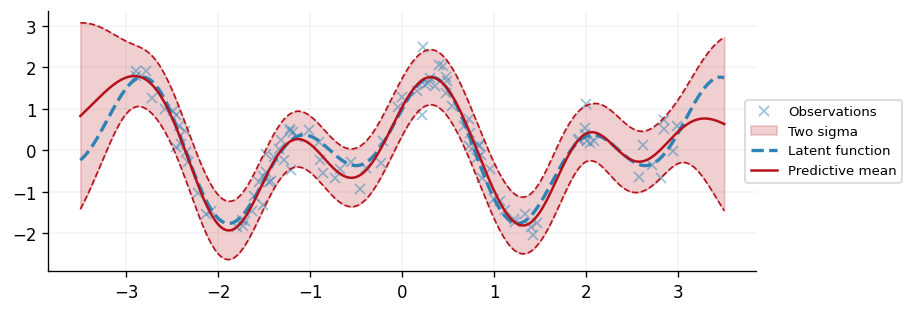

In [10]:
fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.plot(x, y, "x", label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest, ytest, label="Latent function", color=cols[0], linestyle="--", linewidth=2
)
ax.plot(xtest, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))